# Preliminary mechanism analysis to validate dataset usability and explore trends in mechanisms
## Code 6
Be sure to update paths accordingly.

In [ ]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import peptides
import json


In [ ]:
import numpy as np

# Hydrophobicity values for each amino acid (Eisenberg scale)
hydro_dict = {
    'A': 0.25, 'R': -1.76, 'N': -0.64, 'D': -0.72, 'C': 0.04,
    'Q': -0.69, 'E': -0.62, 'G': 0.16, 'H': -0.40, 'I': 0.73,
    'L': 0.53, 'K': -1.10, 'M': 0.26, 'F': 0.61, 'P': -0.07,
    'S': -0.26, 'T': -0.18, 'W': 0.37, 'Y': 0.02, 'V': 0.54
}

def compute_hydrophobic_moment(sequence, angle_deg=100):
    """Approximate hydrophobic moment assuming alpha-helix (100° per residue)"""
    angle_rad = np.radians(angle_deg)
    sum_cos = sum(hydro_dict.get(aa, 0) * np.cos(i * angle_rad) for i, aa in enumerate(sequence))
    sum_sin = sum(hydro_dict.get(aa, 0) * np.sin(i * angle_rad) for i, aa in enumerate(sequence))
    return np.sqrt(sum_cos**2 + sum_sin**2) / len(sequence) if sequence else 0


In [ ]:
# Flexibility values from Bhaskaran & Ponnuswamy (1988)
FLEXIBILITY_INDEX = {
    "A": 0.357, "R": 0.529, "N": 0.463, "D": 0.511, "C": 0.346,
    "Q": 0.493, "E": 0.497, "G": 0.544, "H": 0.323, "I": 0.462,
    "L": 0.365, "K": 0.466, "M": 0.295, "F": 0.314, "P": 0.509,
    "S": 0.507, "T": 0.444, "W": 0.305, "Y": 0.420, "V": 0.386
}

def compute_flexibility(sequence):
    values = [FLEXIBILITY_INDEX.get(aa, 0) for aa in sequence]
    return sum(values) / len(values) if values else 0


In [ ]:
with open("filtered_antibacterial_mechanisms.json", "r") as f:
    data = json.load(f)

# Step 4: Convert to DataFrame
df = pd.DataFrame(data).T.reset_index().rename(columns={"index": "id"})

# Step 5: Feature extraction function
def compute_features(sequence):
    analyzed = ProteinAnalysis(sequence)
    peptide = peptides.Peptide(sequence)
    alpha, beta, turn = analyzed.secondary_structure_fraction()
    aa_percent = analyzed.get_amino_acids_percent()

    return {
        "Length (number of amino acids)": len(sequence),
        "Molecular Weight (Daltons)": analyzed.molecular_weight(),
        "Net Charge": analyzed.charge_at_pH(7.0),
        "Charge": peptide.charge(),
        "Charge Density (Charge/Dalton)": analyzed.charge_at_pH(7.0) / analyzed.molecular_weight(),
        "Instability Index": analyzed.instability_index(),
        "Aromaticity": analyzed.aromaticity(),
        "Aliphatic Index": peptide.aliphatic_index(),
        "Boman Index (kcal/mol)": peptide.boman(),
        "Isoelectric Point (pH)": analyzed.isoelectric_point(),
        "Hydrophobic Ratio": analyzed.gravy(),
        "Hydrophobic Moment": compute_hydrophobic_moment(sequence),
        "Flexibility Index": compute_flexibility(sequence),
        "Alpha Helix Content": alpha,
        "Beta Sheet Content": beta,
        "Turn Content": turn,
        **{f"Percent {aa}": aa_percent.get(aa, 0) for aa in "ARNDCEQGHILKMFPSTWYV"}
    }

# Step 6: Apply feature extraction
feature_df = df["sequence"].apply(compute_features).apply(pd.Series)

# Step 7: Combine with mechanism metadata
full_df = pd.concat([df[["id", "sequence", "primary_mechanism", "subtype"]], feature_df], axis=1)

# Step 8: Group by primary mechanism
print("\n=== Average Feature Values by Primary Mechanism ===")
print(full_df.groupby("primary_mechanism").mean(numeric_only=True).round(3))

print("\n=== Standard Deviation of Features by Primary Mechanism ===")
print(full_df.groupby("primary_mechanism").std(numeric_only=True).round(3))

# Step 9: Group by subtype mechanism
print("\n=== Average Feature Values by Subtype Mechanism ===")
print(full_df.groupby("subtype").mean(numeric_only=True).round(3))

print("\n=== Standard Deviation of Features by Subtype Mechanism ===")
print(full_df.groupby("subtype").std(numeric_only=True).round(3))

/usr/local/lib/python3.11/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(



=== Average Feature Values by Primary Mechanism ===
                         Length (number of amino acids)  \
primary_mechanism                                         
biofilm_destruction                              18.750   
carpet                                           15.784   
immunomodulatory                                 44.000   
intracellular_targeting                          22.000   
membrane_disruption                              22.250   
non-lytic                                        18.500   
pore                                             22.016   

                         Molecular Weight (Daltons)  Net Charge  Charge  \
primary_mechanism                                                         
biofilm_destruction                        2381.383       9.166   9.497   
carpet                                     1940.848       3.687   3.958   
immunomodulatory                           4709.465       2.262   2.501   
intracellular_targeting                 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


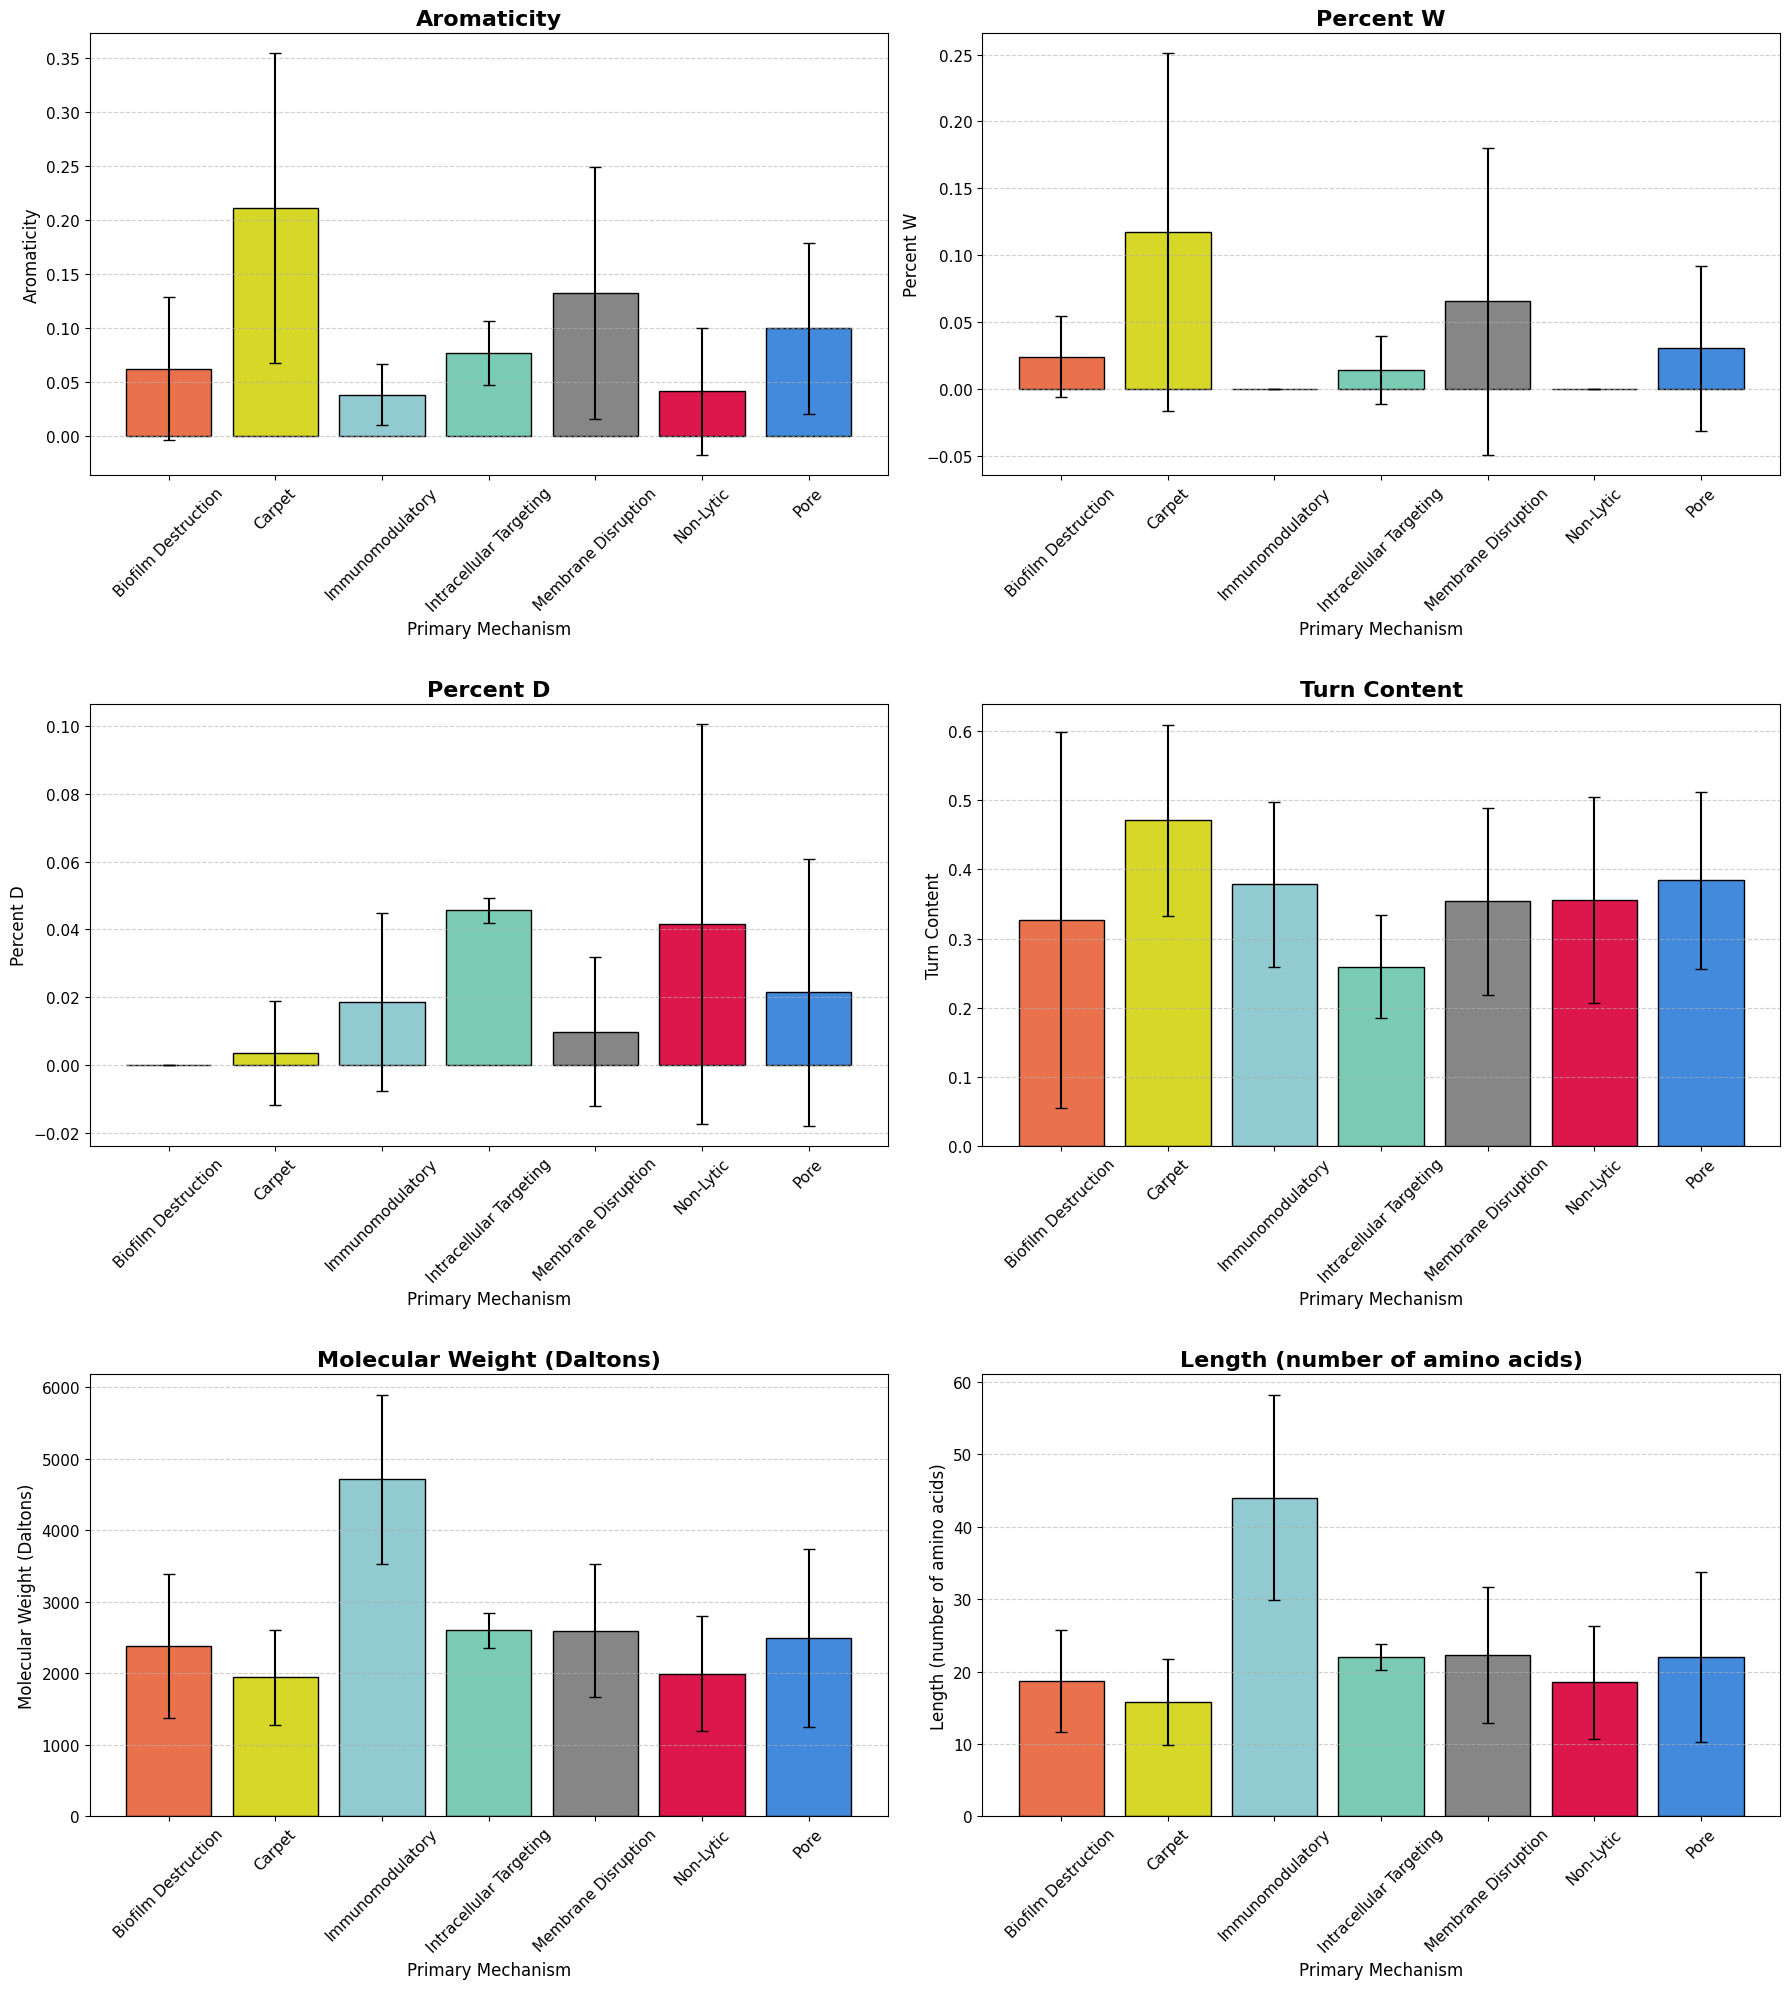

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the main figure features
main_features = [
    "Aromaticity",
    "Percent W",
    "Percent D",
    "Turn Content",
    "Molecular Weight (Daltons)",
    "Length (number of amino acids)"
]

# Mechanism color map

mechanism_colors = {
    "biofilm_destruction":  "#e9724d",
    "carpet": "#d6d727",
    "immunomodulatory": "#92cad1",
    "intracellular_targeting": "#79ccb3",
    "membrane_disruption": "#868686",
    "non-lytic": "#dd164c",
    "pore": "#438add"

}


# Clean label function
def format_mechanism_name(name):
    return name.replace("_", " ").title()

# Filter to valid mechanisms and features
full_df_clean = full_df.dropna(subset=["primary_mechanism"])
full_df_clean = full_df_clean[main_features + ["primary_mechanism"]].dropna()

# Group and aggregate
grouped = full_df_clean.groupby("primary_mechanism")[main_features]
means = grouped.mean()
stds = grouped.std()

# Create 3x2 grid of bar plots
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for i, feature in enumerate(main_features):
    ax = axes[i]
    mean_vals = means[feature]
    std_vals = stds[feature]

    mechanisms = mean_vals.index.tolist()
    colors = [mechanism_colors.get(m, "black") for m in mechanisms]

    bars = ax.bar(
        [format_mechanism_name(m) for m in mechanisms],
        mean_vals.values,
        yerr=std_vals.values,
        capsize=4,
        color=colors,
        edgecolor='black'
    )

    ax.set_title(feature, fontsize=16, fontweight='bold')
    ax.set_ylabel(feature, fontsize=12)
    ax.set_xlabel("Primary Mechanism", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Final layout
plt.tight_layout(h_pad=3.0)
plt.savefig("/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project/Figure_Main_Mechanism_Barplots.png", dpi=300)
plt.show()


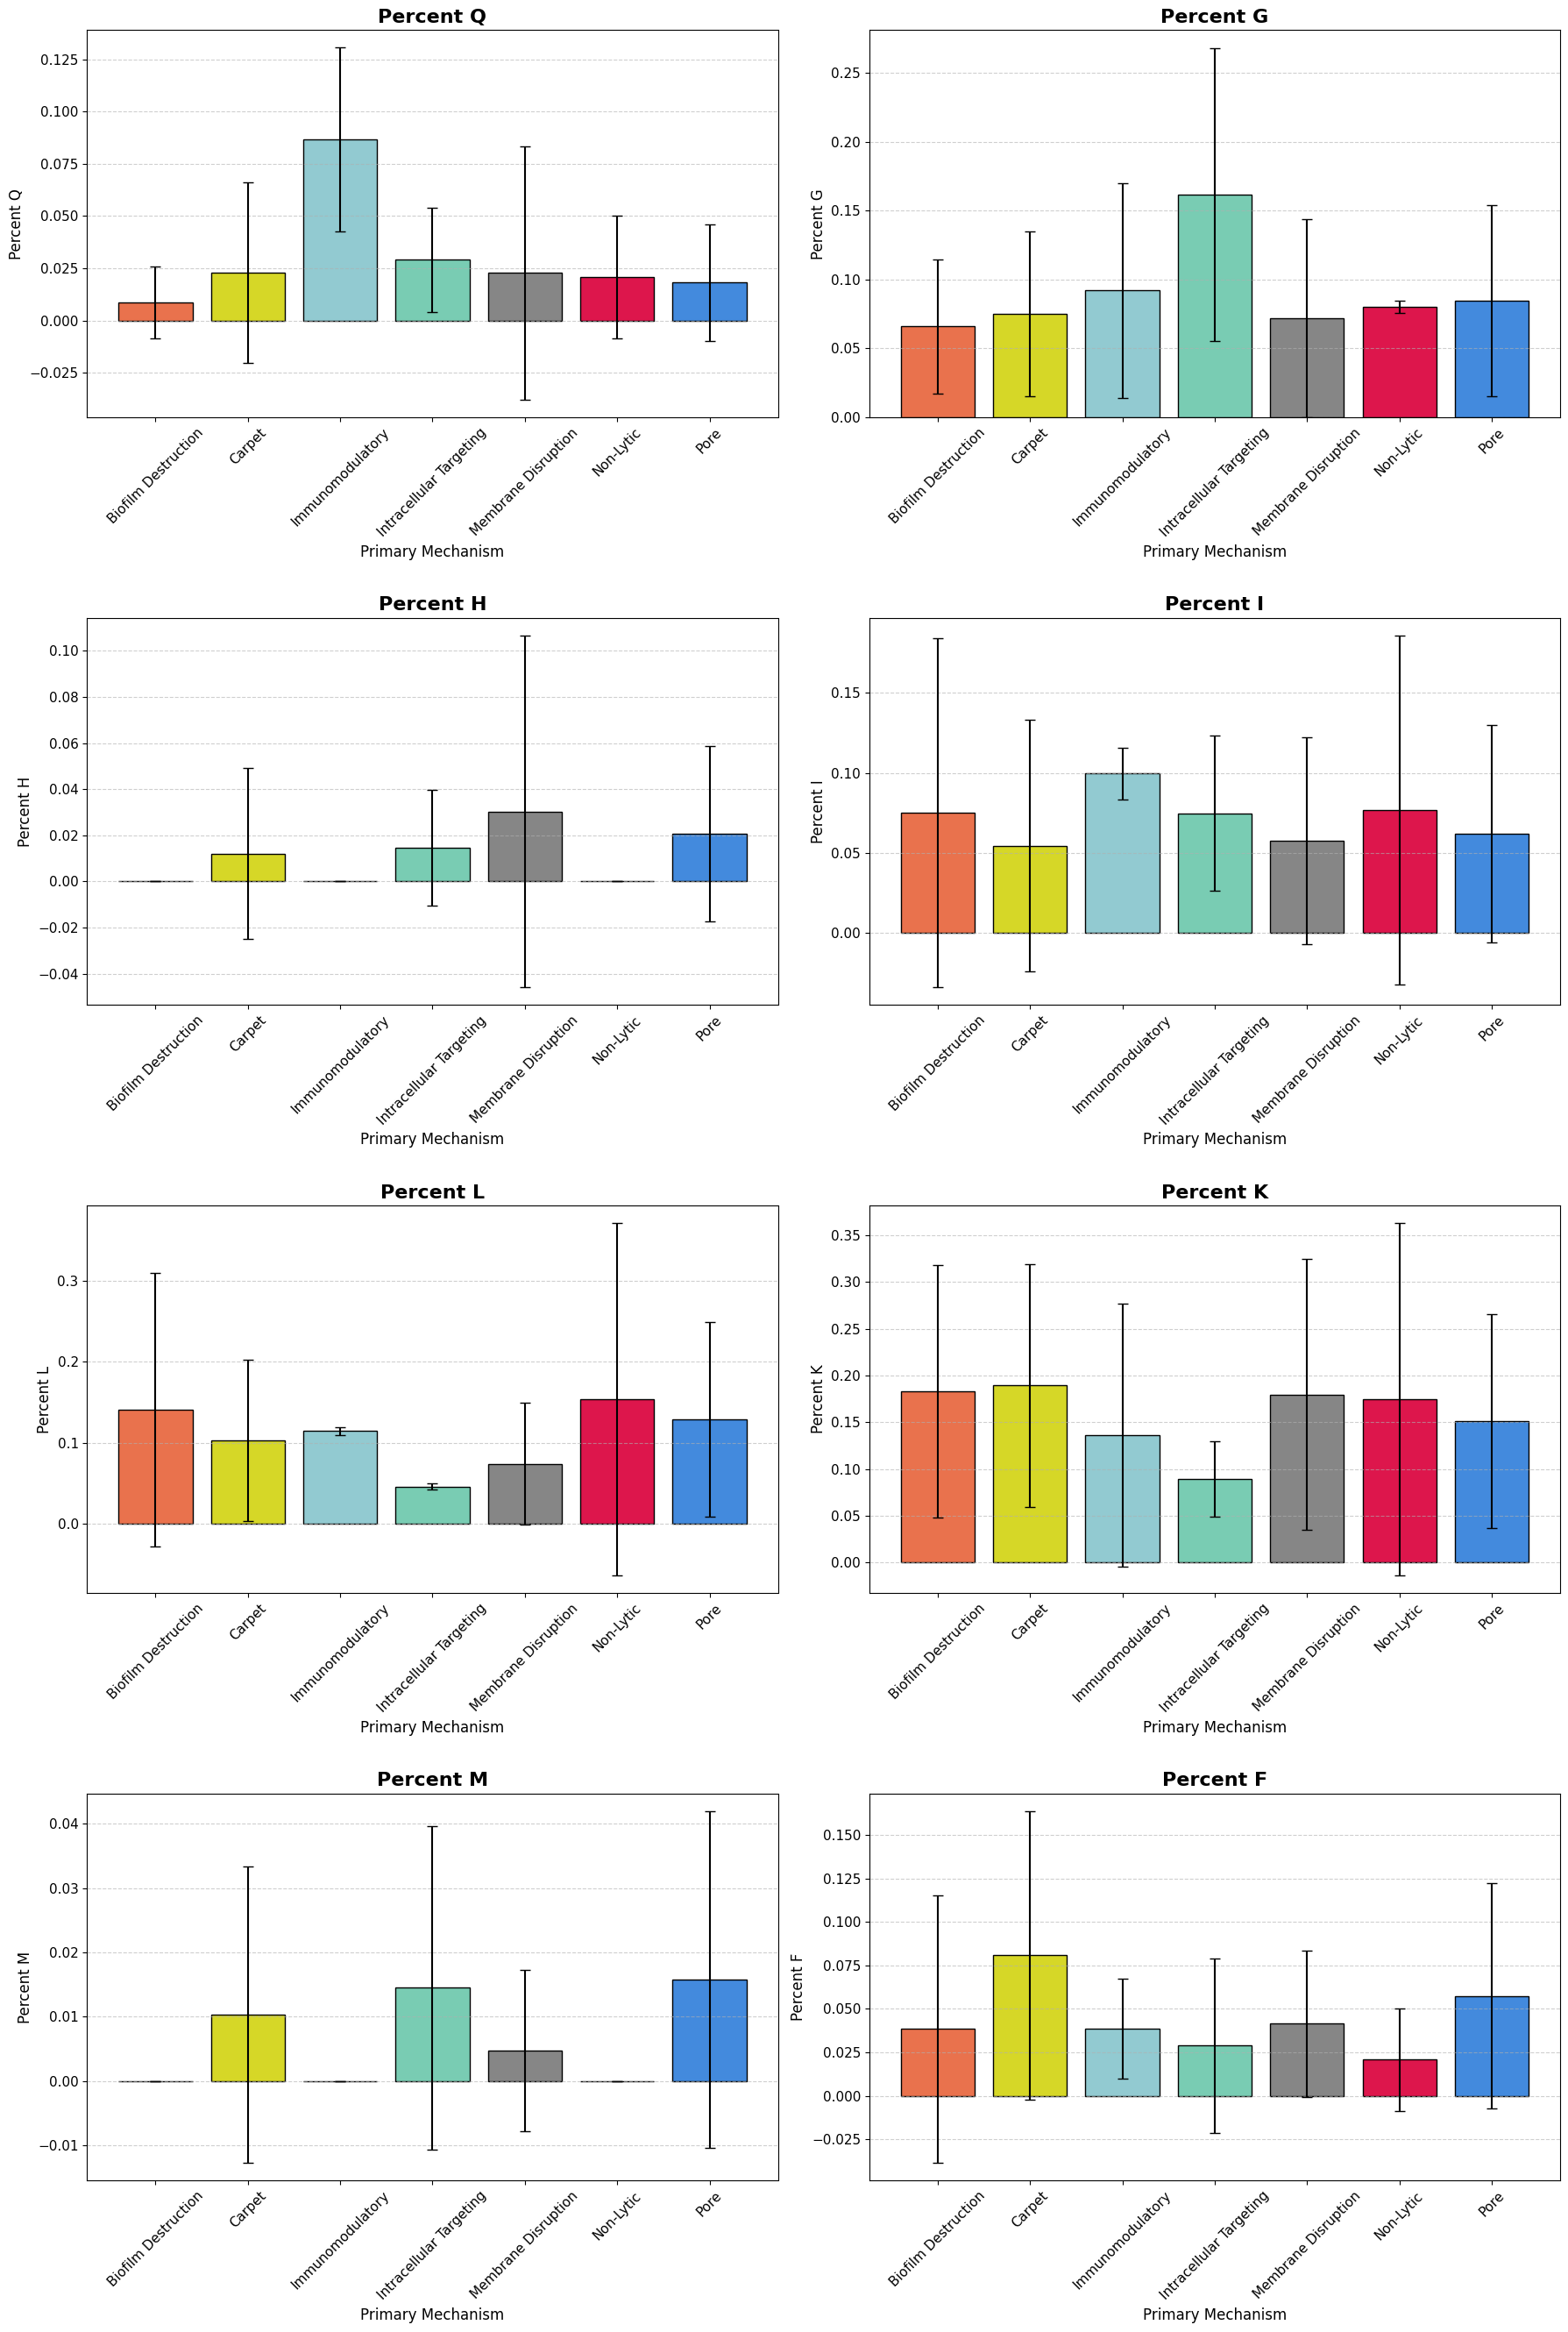

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define the main figure features
'''
main_features = [
    "Net Charge",
    "Charge Density (Charge/Dalton)",
    "Instability Index",
    "Aliphatic Index",
    "Boman Index (kcal/mol)",
    "Isoelectric Point (pH)",
    "Hydrophobic Ratio",
    "Hydrophobic Moment",
]

main_features = [
    "Flexibility Index",
    "Alpha Helix Content",
    "Beta Sheet Content",
] + [f"Percent {aa}" for aa in "ARNCE"]
'''
main_features = [f"Percent {aa}" for aa in "QGHILKMF"]
#main_features = [f"Percent {aa}" for aa in "PSTYV"]

# Mechanism color map

mechanism_colors = {
    "biofilm_destruction":  "#e9724d",
    "carpet": "#d6d727",
    "immunomodulatory": "#92cad1",
    "intracellular_targeting": "#79ccb3",
    "membrane_disruption": "#868686",
    "non-lytic": "#dd164c",
    "pore": "#438add"

}


# Clean label function
def format_mechanism_name(name):
    return name.replace("_", " ").title()

# Filter to valid mechanisms and features
full_df_clean = full_df.dropna(subset=["primary_mechanism"])
full_df_clean = full_df_clean[main_features + ["primary_mechanism"]].dropna()

# Group and aggregate
grouped = full_df_clean.groupby("primary_mechanism")[main_features]
means = grouped.mean()
stds = grouped.std()

# Create 3x2 grid of bar plots
fig, axes = plt.subplots(4, 2, figsize=(18, 26.7))
axes = axes.flatten()

for i, feature in enumerate(main_features):
    ax = axes[i]
    mean_vals = means[feature]
    std_vals = stds[feature]

    mechanisms = mean_vals.index.tolist()
    colors = [mechanism_colors.get(m, "black") for m in mechanisms]

    bars = ax.bar(
        [format_mechanism_name(m) for m in mechanisms],
        mean_vals.values,
        yerr=std_vals.values,
        capsize=4,
        color=colors,
        edgecolor='black'
    )

    ax.set_title(feature, fontsize=16, fontweight='bold')
    ax.set_ylabel(feature, fontsize=12)
    ax.set_xlabel("Primary Mechanism", fontsize=12)
    ax.tick_params(axis='x', labelrotation=45, labelsize=11)
    ax.tick_params(axis='y', labelsize=11)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

# Final layout
plt.tight_layout(h_pad=3.0)
plt.savefig("/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project/Figure_Supplementary_Mechanism_Barplots3.png", dpi=300)
plt.show()


In [ ]:
!pip install scikit-posthocs

In [ ]:
import pandas as pd
import scipy.stats as stats
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

# Select numeric features to test
features_to_test = full_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
features_to_test = [col for col in features_to_test if col not in ["id"]]  # Exclude non-feature columns

# Store results
kruskal_results = []

for feature in features_to_test:
    groups = [group[feature].dropna() for name, group in full_df.groupby("primary_mechanism") if len(group[feature].dropna()) > 0]

    if len(groups) >= 2:
        stat, p_value = stats.kruskal(*groups)
        kruskal_results.append((feature, stat, p_value))

# Print Kruskal-Wallis results
kw_df = pd.DataFrame(kruskal_results, columns=["Feature", "Kruskal-Wallis Statistic", "p-value"])
kw_df["Significant (p < 0.05)"] = kw_df["p-value"] < 0.05

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

print("🔬 Kruskal-Wallis Test Results by Feature:")
display(kw_df.sort_values("p-value"))

# Optional: run Dunn's test for significant features
for feature, _, p in kruskal_results:
    if p < 0.05:
        print(f"\n📊 Dunn’s post-hoc test for: {feature}")
        dunn = sp.posthoc_dunn(full_df, val_col=feature, group_col="primary_mechanism", p_adjust='bonferroni')
        display(dunn.round(3))


🔬 Kruskal-Wallis Test Results by Feature:


,Feature,Kruskal-Wallis Statistic,p-value,Significant (p < 0.05)
6,Aromaticity,24.292507,0.000461,True
33,Percent W,22.500024,0.000982,True
19,Percent D,22.078394,0.001172,True
15,Turn Content,18.937908,0.004270,True
1,Molecular Weight (Daltons),18.005772,0.006218,True
0,Length (number of amino acids),17.495895,0.007624,True
16,Percent A,16.650008,0.010659,True
12,Flexibility Index,16.315452,0.012157,True
18,Percent N,15.396740,0.017386,True
11,Hydrophobic Moment,15.122675,0.019324,True



📊 Dunn’s post-hoc test for: Length (number of amino acids)


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.000,1.0,1.000,1.0,1.000
carpet,1.0,1.000,0.101,1.0,0.062,1.0,0.022
immunomodulatory,1.0,0.101,1.000,1.0,1.000,1.0,0.929
intracellular_targeting,1.0,1.000,1.000,1.0,1.000,1.0,1.000
membrane_disruption,1.0,0.062,1.000,1.0,1.000,1.0,1.000
non-lytic,1.0,1.000,1.000,1.0,1.000,1.0,1.000
pore,1.0,0.022,0.929,1.0,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Molecular Weight (Daltons)


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.000,1.0,1.000,1.0,1.000
carpet,1.0,1.000,0.090,1.0,0.025,1.0,0.074
immunomodulatory,1.0,0.090,1.000,1.0,1.000,1.0,0.677
intracellular_targeting,1.0,1.000,1.000,1.0,1.000,1.0,1.000
membrane_disruption,1.0,0.025,1.000,1.0,1.000,1.0,1.000
non-lytic,1.0,1.000,1.000,1.0,1.000,1.0,1.000
pore,1.0,0.074,0.677,1.0,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Aromaticity


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.000,0.307,1.000,1.0,1.000,1.000,1.0
carpet,0.307,1.000,0.486,1.0,0.277,0.624,0.0
immunomodulatory,1.000,0.486,1.000,1.0,1.000,1.000,1.0
intracellular_targeting,1.000,1.000,1.000,1.0,1.000,1.000,1.0
membrane_disruption,1.000,0.277,1.000,1.0,1.000,1.000,1.0
non-lytic,1.000,0.624,1.000,1.0,1.000,1.000,1.0
pore,1.000,0.000,1.000,1.0,1.000,1.000,1.0



📊 Dunn’s post-hoc test for: Hydrophobic Ratio


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.0,1.00,1.000,1.0,1.000
carpet,1.0,1.000,1.0,1.00,1.000,1.0,0.325
immunomodulatory,1.0,1.000,1.0,1.00,1.000,1.0,1.000
intracellular_targeting,1.0,1.000,1.0,1.00,1.000,1.0,0.240
membrane_disruption,1.0,1.000,1.0,1.00,1.000,1.0,0.417
non-lytic,1.0,1.000,1.0,1.00,1.000,1.0,1.000
pore,1.0,0.325,1.0,0.24,0.417,1.0,1.000



📊 Dunn’s post-hoc test for: Hydrophobic Moment


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.0,1.0,1.000,1.000,1.0
carpet,1.0,1.000,1.0,1.0,0.027,0.339,0.3
immunomodulatory,1.0,1.000,1.0,1.0,1.000,1.000,1.0
intracellular_targeting,1.0,1.000,1.0,1.0,1.000,1.000,1.0
membrane_disruption,1.0,0.027,1.0,1.0,1.000,1.000,1.0
non-lytic,1.0,0.339,1.0,1.0,1.000,1.000,1.0
pore,1.0,0.300,1.0,1.0,1.000,1.000,1.0



📊 Dunn’s post-hoc test for: Flexibility Index


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.0,1.000,1.000,1.0,1.000
carpet,1.0,1.000,1.0,0.025,1.000,1.0,0.767
immunomodulatory,1.0,1.000,1.0,1.000,1.000,1.0,1.000
intracellular_targeting,1.0,0.025,1.0,1.000,0.261,1.0,0.163
membrane_disruption,1.0,1.000,1.0,0.261,1.000,1.0,1.000
non-lytic,1.0,1.000,1.0,1.000,1.000,1.0,1.000
pore,1.0,0.767,1.0,0.163,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Turn Content


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.0,1.000,1.000,1.0,1.000
carpet,1.0,1.000,1.0,0.108,0.009,1.0,0.012
immunomodulatory,1.0,1.000,1.0,1.000,1.000,1.0,1.000
intracellular_targeting,1.0,0.108,1.0,1.000,1.000,1.0,1.000
membrane_disruption,1.0,0.009,1.0,1.000,1.000,1.0,1.000
non-lytic,1.0,1.000,1.0,1.000,1.000,1.0,1.000
pore,1.0,0.012,1.0,1.000,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Percent A


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.0,1.0,1.000,1.0,1.000
carpet,1.0,1.000,1.0,1.0,0.233,1.0,0.003
immunomodulatory,1.0,1.000,1.0,1.0,1.000,1.0,1.000
intracellular_targeting,1.0,1.000,1.0,1.0,1.000,1.0,1.000
membrane_disruption,1.0,0.233,1.0,1.0,1.000,1.0,1.000
non-lytic,1.0,1.000,1.0,1.0,1.000,1.0,1.000
pore,1.0,0.003,1.0,1.0,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Percent N


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.000,1.0,1.000,1.0,1.000
carpet,1.0,1.000,0.144,1.0,0.201,1.0,0.080
immunomodulatory,1.0,0.144,1.000,1.0,1.000,1.0,0.971
intracellular_targeting,1.0,1.000,1.000,1.0,1.000,1.0,1.000
membrane_disruption,1.0,0.201,1.000,1.0,1.000,1.0,1.000
non-lytic,1.0,1.000,1.000,1.0,1.000,1.0,1.000
pore,1.0,0.080,0.971,1.0,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Percent D


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.000,1.000,1.0,0.086,1.000,1.0,1.000
carpet,1.000,1.000,1.0,0.013,1.000,1.0,0.020
immunomodulatory,1.000,1.000,1.0,1.000,1.000,1.0,1.000
intracellular_targeting,0.086,0.013,1.0,1.000,0.078,1.0,0.286
membrane_disruption,1.000,1.000,1.0,0.078,1.000,1.0,1.000
non-lytic,1.000,1.000,1.0,1.000,1.000,1.0,1.000
pore,1.000,0.020,1.0,0.286,1.000,1.0,1.000



📊 Dunn’s post-hoc test for: Percent E


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.000,1.000,0.189,1.000,1.000,1.000,1.000
carpet,1.000,1.000,0.100,1.000,1.000,1.000,0.663
immunomodulatory,0.189,0.100,1.000,0.277,0.574,0.497,0.438
intracellular_targeting,1.000,1.000,0.277,1.000,1.000,1.000,1.000
membrane_disruption,1.000,1.000,0.574,1.000,1.000,1.000,1.000
non-lytic,1.000,1.000,0.497,1.000,1.000,1.000,1.000
pore,1.000,0.663,0.438,1.000,1.000,1.000,1.000



📊 Dunn’s post-hoc test for: Percent W


,biofilm_destruction,carpet,immunomodulatory,intracellular_targeting,membrane_disruption,non-lytic,pore
biofilm_destruction,1.0,1.000,1.000,1.0,1.0,1.000,1.0
carpet,1.0,1.000,0.999,1.0,1.0,0.999,0.0
immunomodulatory,1.0,0.999,1.000,1.0,1.0,1.000,1.0
intracellular_targeting,1.0,1.000,1.000,1.0,1.0,1.000,1.0
membrane_disruption,1.0,1.000,1.000,1.0,1.0,1.000,1.0
non-lytic,1.0,0.999,1.000,1.0,1.0,1.000,1.0
pore,1.0,0.000,1.000,1.0,1.0,1.000,1.0


In [ ]:
import pandas as pd
import numpy as np
import scikit_posthocs as sp
from itertools import combinations
from scipy.stats import ttest_ind

# === Function to compute Cohen's d ===
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1)**2 + (ny - 1) * np.std(y, ddof=1)**2) / (nx + ny - 2))
    if pooled_std == 0:
        return np.nan
    return (np.mean(x) - np.mean(y)) / pooled_std

# === Collect all primary mechanisms ===
mechanisms = full_df["primary_mechanism"].dropna().unique()

# === Identify numeric features to test ===
excluded_cols = ['id', 'sequence', 'primary_mechanism', 'subtype']
features_to_test = [col for col in full_df.select_dtypes(include=["float", "int"]).columns if col not in excluded_cols]

print(f"Found {len(features_to_test)} features to test:\n", features_to_test)

# === Collect all results ===
all_effects = []

for feature in features_to_test:

    # Try Dunn’s test (optional, for significance annotation)
    try:
        dunn_df = sp.posthoc_dunn(full_df, val_col=feature, group_col="primary_mechanism", p_adjust='bonferroni')
    except Exception as e:
        print(f"Skipping Dunn’s test for {feature} due to error: {e}")
        dunn_df = None

    # Pairwise Cohen's d
    for g1, g2 in combinations(mechanisms, 2):
        values_g1 = full_df[full_df["primary_mechanism"] == g1][feature].dropna()
        values_g2 = full_df[full_df["primary_mechanism"] == g2][feature].dropna()

        if len(values_g1) < 2 or len(values_g2) < 2:
            continue  # skip comparison if insufficient data

        d_val = cohen_d(values_g1, values_g2)

        # Interpret effect size
        if np.isnan(d_val):
            interpretation = "undefined"
        elif abs(d_val) < 0.2:
            interpretation = "negligible"
        elif abs(d_val) < 0.5:
            interpretation = "small"
        elif abs(d_val) < 0.8:
            interpretation = "medium"
        else:
            interpretation = "large"

        # Dunn p-value if available
        dunn_p = None
        if dunn_df is not None:
            try:
                dunn_p = dunn_df.loc[g1, g2] if g1 in dunn_df.index and g2 in dunn_df.columns else dunn_df.loc[g2, g1]
            except:
                pass

        all_effects.append({
            "Feature": feature,
            "Group 1": g1,
            "Group 2": g2,
            "Cohen's d": round(d_val, 3),
            "Effect size": interpretation,
            "Dunn p-value": round(dunn_p, 4) if isinstance(dunn_p, float) else "N/A",
            "Dunn Significant (p < 0.05)": dunn_p < 0.05 if isinstance(dunn_p, float) else "N/A"
        })

# === Convert to DataFrame and Display ===
cohen_results_df = pd.DataFrame(all_effects)
from IPython.display import display
display(cohen_results_df)

cohen_results_df.to_csv("cohen_d_results_all_features.csv", index=False)

Found 36 features to test:
 ['Length (number of amino acids)', 'Molecular Weight (Daltons)', 'Net Charge', 'Charge', 'Charge Density (Charge/Dalton)', 'Instability Index', 'Aromaticity', 'Aliphatic Index', 'Boman Index (kcal/mol)', 'Isoelectric Point (pH)', 'Hydrophobic Ratio', 'Hydrophobic Moment', 'Flexibility Index', 'Alpha Helix Content', 'Beta Sheet Content', 'Turn Content', 'Percent A', 'Percent R', 'Percent N', 'Percent D', 'Percent C', 'Percent E', 'Percent Q', 'Percent G', 'Percent H', 'Percent I', 'Percent L', 'Percent K', 'Percent M', 'Percent F', 'Percent P', 'Percent S', 'Percent T', 'Percent W', 'Percent Y', 'Percent V']


,Feature,Group 1,Group 2,Cohen's d,Effect size,Dunn p-value,Dunn Significant (p < 0.05)
0,Length (number of amino acids),membrane_disruption,pore,0.021,negligible,1.0000,False
1,Length (number of amino acids),membrane_disruption,carpet,0.823,large,0.0616,False
2,Length (number of amino acids),membrane_disruption,biofilm_destruction,0.378,small,1.0000,False
3,Length (number of amino acids),membrane_disruption,non-lytic,0.400,small,1.0000,False
4,Length (number of amino acids),membrane_disruption,immunomodulatory,-2.270,large,1.0000,False
...,...,...,...,...,...,...,...
751,Percent V,biofilm_destruction,immunomodulatory,-1.729,large,1.0000,False
752,Percent V,biofilm_destruction,intracellular_targeting,-0.356,small,1.0000,False
753,Percent V,non-lytic,immunomodulatory,-1.378,large,1.0000,False
754,Percent V,non-lytic,intracellular_targeting,-0.707,medium,1.0000,False


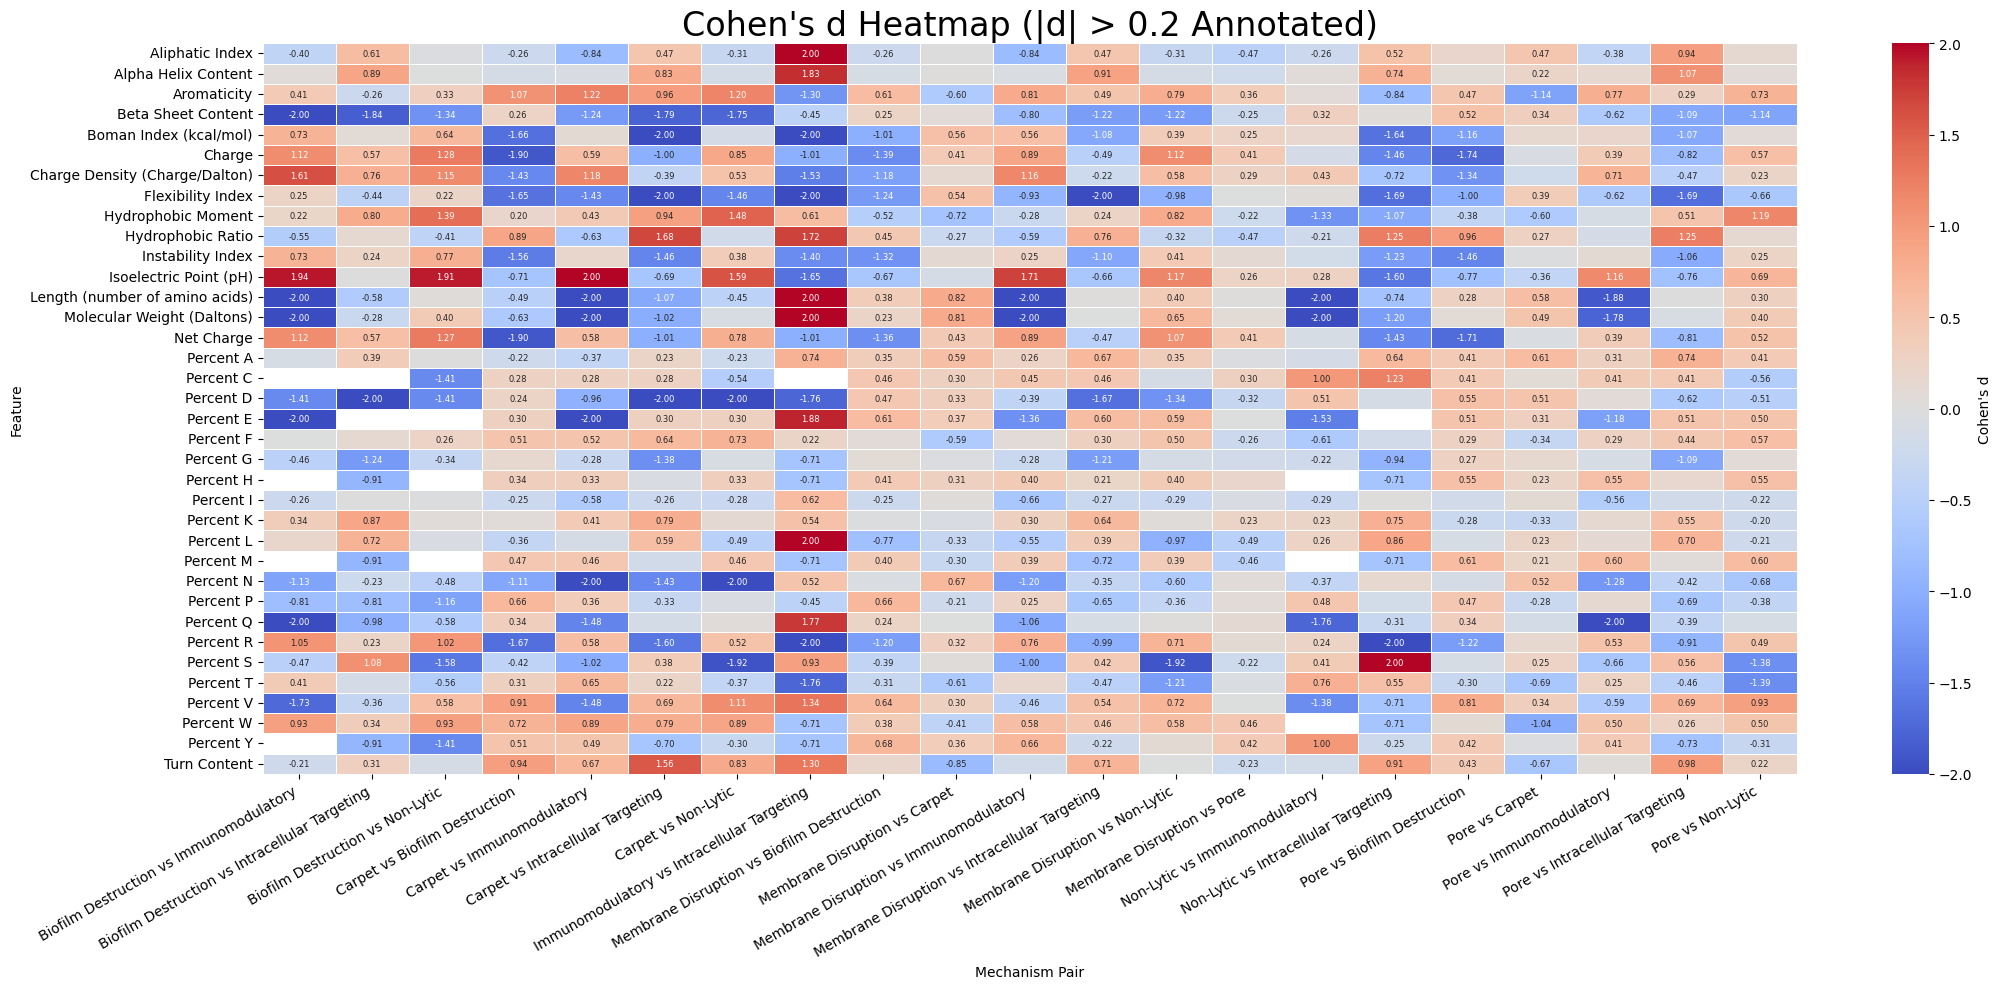

'\n# === Heatmap 2: No annotations ===\nplt.figure(figsize=(22, 10))\nsns.heatmap(\n    pivot_capped,\n    cmap="coolwarm",\n    fmt="",\n    center=0,\n    linewidths=0.5,\n    cbar_kws={"label": "Cohen\'s d"}\n)\nplt.title("Cohen\'s d Heatmap (No Annotations)", fontsize=16)\nplt.xlabel("Mechanism Pair")\nplt.ylabel("Feature")\nplt.xticks(rotation=45, ha="right", fontsize=8)\nplt.yticks(fontsize=9)\nplt.tight_layout()\nplt.show()\n'

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to prettify mechanism names
def format_mechanism_name(name):
    return name.replace("_", " ").title()

# Create pair label for each group combination
cohen_results_df["Pair"] = cohen_results_df["Group 1"] + " vs " + cohen_results_df["Group 2"]

# Format the pair labels
cohen_results_df["Pair"] = cohen_results_df["Pair"].apply(
    lambda x: " vs ".join([format_mechanism_name(g) for g in x.split(" vs ")])
)

# Step 1: Pivot table: Features x Pair Labels
pivot_df = cohen_results_df.pivot_table(
    index="Feature",
    columns="Pair",
    values="Cohen's d",
    aggfunc="first"
)

# Step 2: Cap d-values for better color scaling
pivot_capped = pivot_df.clip(-2, 2)

# Step 3: Annotate only d-values with magnitude > 0.2
annot_masked = pivot_capped.copy()
annot_masked = annot_masked.applymap(
    lambda x: f"{x:.2f}" if isinstance(x, (int, float)) and abs(x) > 0.2 else ""
)

# === Heatmap 1: Annotate only |d| > 0.2 ===
plt.figure(figsize=(22, 10))
sns.heatmap(
    pivot_capped,
    annot=annot_masked,
    cmap="coolwarm",
    fmt="",
    center=0,
    linewidths=0.5,
    annot_kws={"size": 6},
    cbar_kws={"label": "Cohen's d"}
)
plt.title("Cohen's d Heatmap (|d| > 0.2 Annotated)", fontsize=24)
plt.xlabel("Mechanism Pair")
plt.ylabel("Feature")
plt.xticks(rotation=30, ha="right", fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project/cohens_d_heatmap_prelim_mech_analysis.png", dpi=300)
plt.show()

'''
# === Heatmap 2: No annotations ===
plt.figure(figsize=(22, 10))
sns.heatmap(
    pivot_capped,
    cmap="coolwarm",
    fmt="",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Cohen's d"}
)
plt.title("Cohen's d Heatmap (No Annotations)", fontsize=16)
plt.xlabel("Mechanism Pair")
plt.ylabel("Feature")
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()
'''

In [ ]:
pip install adjustText

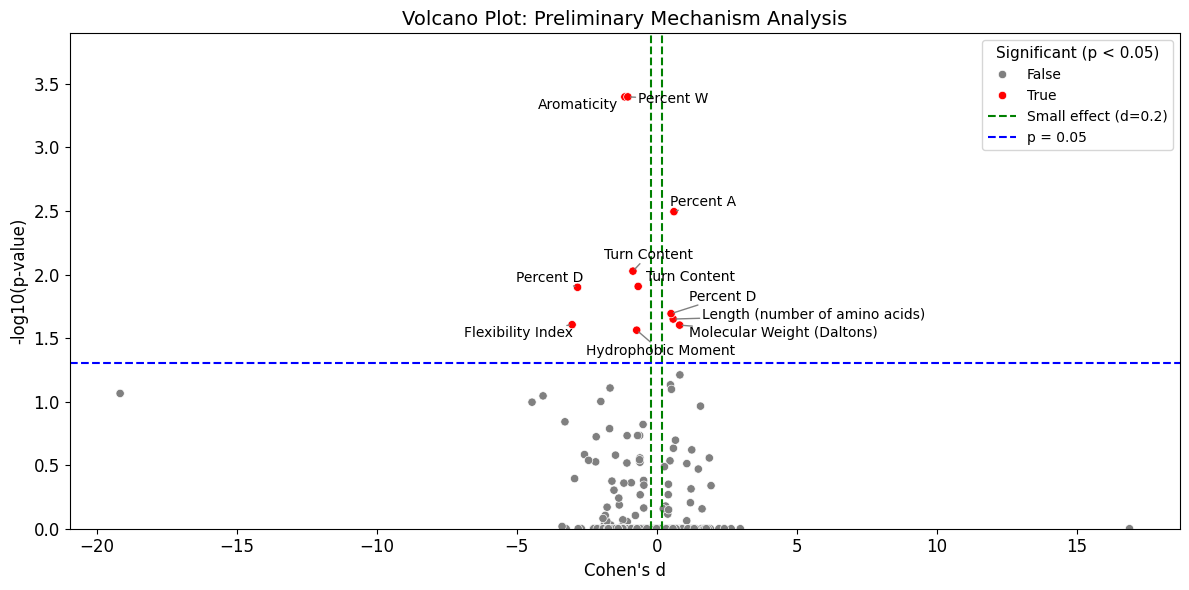

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

# Copy and clean
volcano_df = cohen_results_df.copy()
volcano_df = volcano_df[volcano_df["Dunn p-value"].apply(lambda x: isinstance(x, (float, int)))].copy()

# Rename columns to match consistent style
volcano_df["p_value"] = volcano_df["Dunn p-value"].astype(float)
volcano_df["Cohen_d"] = volcano_df["Cohen's d"]
volcano_df["-log10(p_value)"] = -np.log10(volcano_df["p_value"])

# Drop any rows with missing values
volcano_df = volcano_df.dropna(subset=["p_value", "Cohen_d", "-log10(p_value)"])

# Volcano plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=volcano_df,
    x="Cohen_d",
    y="-log10(p_value)",
    hue=volcano_df["p_value"] < 0.05,
    palette={True: "red", False: "gray"}
)

# Reference lines
plt.axvline(x=0.2, linestyle="--", color="green", label="Small effect (d=0.2)")
plt.axvline(x=-0.2, linestyle="--", color="green")
plt.axhline(y=-np.log10(0.05), linestyle="--", color="blue", label="p = 0.05")

# Annotate red points
texts = []
for _, row in volcano_df.iterrows():
    if row["p_value"] < 0.05:
      texts.append(
            plt.text(
                row["Cohen_d"], row["-log10(p_value)"], row["Feature"],
                fontsize=10, ha='center', va='center'
            )
        )
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))
# Labels and style
plt.xlabel("Cohen's d", fontsize=12)
plt.ylabel("-log10(p-value)", fontsize=12)
plt.title("Volcano Plot: Preliminary Mechanism Analysis", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, volcano_df["-log10(p_value)"].max() + 0.5)
plt.legend(title="Significant (p < 0.05)", title_fontsize=11, fontsize=10)
plt.tight_layout()

# Save plot
plt.savefig("/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project/mechanism_volcano_plot.png", dpi=300)
plt.show()


August 18 PCA analysis

In [ ]:
with open("dapam_with_uniprot.json", "r") as f:
    data = json.load(f)

# Step 4: Convert to DataFrame
df = pd.DataFrame(data).reset_index().rename(columns={"index": "id"})

# Step 5: Feature extraction function
def compute_features(sequence):
    analyzed = ProteinAnalysis(sequence)
    peptide = peptides.Peptide(sequence)
    alpha, beta, turn = analyzed.secondary_structure_fraction()
    aa_percent = analyzed.get_amino_acids_percent()

    return {
        "Length (number of amino acids)": len(sequence),
        "Molecular Weight (Daltons)": analyzed.molecular_weight(),
        "Net Charge": analyzed.charge_at_pH(7.0),
        "Charge": peptide.charge(),
        "Charge Density (Charge/Dalton)": analyzed.charge_at_pH(7.0) / analyzed.molecular_weight(),
        "Instability Index": analyzed.instability_index(),
        "Aromaticity": analyzed.aromaticity(),
        "Aliphatic Index": peptide.aliphatic_index(),
        "Boman Index (kcal/mol)": peptide.boman(),
        "Isoelectric Point (pH)": analyzed.isoelectric_point(),
        "Hydrophobic Ratio": analyzed.gravy(),
        "Hydrophobic Moment": compute_hydrophobic_moment(sequence),
        "Flexibility Index": compute_flexibility(sequence),
        "Alpha Helix Content": alpha,
        "Beta Sheet Content": beta,
        "Turn Content": turn,
        **{f"Percent {aa}": aa_percent.get(aa, 0) for aa in "ARNDCEQGHILKMFPSTWYV"}
    }

# Step 6: Apply feature extraction
feature_df = df["sequence"].apply(compute_features).apply(pd.Series)

# Step 7: Combine with mechanism metadata
full_df = pd.concat([df[["id", "sequence", "mechanism", "subtype"]], feature_df], axis=1)

# Step 8: Group by primary mechanism
print("\n=== Average Feature Values by Primary Mechanism ===")
print(full_df.groupby("mechanism").mean(numeric_only=True).round(3))

print("\n=== Standard Deviation of Features by Primary Mechanism ===")
print(full_df.groupby("mechanism").std(numeric_only=True).round(3))

# Step 9: Group by subtype mechanism
print("\n=== Average Feature Values by Subtype Mechanism ===")
print(full_df.groupby("subtype").mean(numeric_only=True).round(3))

print("\n=== Standard Deviation of Features by Subtype Mechanism ===")
print(full_df.groupby("subtype").std(numeric_only=True).round(3))

/usr/local/lib/python3.11/dist-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(



=== Average Feature Values by Primary Mechanism ===
                              id  Length (number of amino acids)  \
mechanism                                                          
biofilm_destruction      106.750                          18.750   
carpet                   100.811                          15.784   
immunomodulatory         101.000                          44.000   
intracellular_targeting  163.000                          22.000   
membrane_disruption      105.278                          22.250   
non-lytic                110.000                          18.500   
pore                     102.177                          22.016   

                         Molecular Weight (Daltons)  Net Charge  Charge  \
mechanism                                                                 
biofilm_destruction                        2381.383       9.166   9.497   
carpet                                     1940.848       3.687   3.958   
immunomodulatory                  

In [ ]:
full_df.head(100)

,id,sequence,mechanism,subtype,Length (number of amino acids),Molecular Weight (Daltons),Net Charge,Charge,Charge Density (Charge/Dalton),Instability Index,...,Percent L,Percent K,Percent M,Percent F,Percent P,Percent S,Percent T,Percent W,Percent Y,Percent V
0,0,AGALTINSDGTSGAVVKVPI,membrane_disruption,,20.0,1870.1086,-0.204004,-0.001864,-0.000109,0.710000,...,0.050000,0.050000,0.000000,0.000000,0.050000,0.100000,0.100000,0.000000,0.000000,0.150000
1,1,AHSIIYGVRGRGRI,pore,,14.0,1554.7978,2.882020,3.088033,0.001854,-14.971429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.000000,0.000000,0.071429,0.071429
2,2,AIAVLGEAKALMGRNIRNGIVKAGPAIAVLGEAKAL,membrane_disruption,,36.0,3557.2594,2.798479,3.000643,0.000787,20.252778,...,0.111111,0.083333,0.027778,0.000000,0.027778,0.000000,0.000000,0.000000,0.000000,0.083333
3,3,AKKVFKRLEKLFSKIQNDK,pore,,19.0,2320.7746,4.793802,4.998432,0.002066,0.847368,...,0.105263,0.315789,0.000000,0.105263,0.000000,0.052632,0.000000,0.000000,0.000000,0.052632
4,4,AKKVFKRLPKLFSKIWNWK,pore,,19.0,2417.9790,6.789871,6.996211,0.002808,16.489474,...,0.105263,0.315789,0.000000,0.105263,0.052632,0.052632,0.000000,0.105263,0.000000,0.052632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,ITSISLCTPGCKTGALMGCSFFGWVSACKNC,pore,,31.0,3186.7890,1.708599,1.687521,0.000536,29.203226,...,0.064516,0.064516,0.032258,0.064516,0.032258,0.129032,0.096774,0.032258,0.000000,0.032258
96,96,ITSRILCTSSCKTGALMGCNMKTATCHCSIHVSK,pore,,34.0,3587.2890,3.881938,3.869040,0.001082,54.100000,...,0.058824,0.088235,0.058824,0.000000,0.000000,0.147059,0.147059,0.000000,0.000000,0.029412
97,97,IVCGTDFDGR,pore,,10.0,1082.1876,-1.247568,-1.063101,-0.001153,-3.180000,...,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000
98,98,IWSFLIKAATKLLPSLFGGGKKDS,pore,,24.0,2578.0557,2.757226,2.997251,0.001069,33.329167,...,0.166667,0.166667,0.000000,0.083333,0.041667,0.125000,0.041667,0.041667,0.000000,0.000000


In [ ]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Save the label separately
mechanisms = full_df["mechanism"]

# Drop non-numeric or label columns
X = full_df.drop(columns=["sequence", "mechanism", "id", "subtype"], errors="ignore")


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # You can go higher for explained variance analysis
X_pca = pca.fit_transform(X_scaled)

# Add PCA results to DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=["PC1", "PC2"])
pca_df["mechanism"] = mechanisms

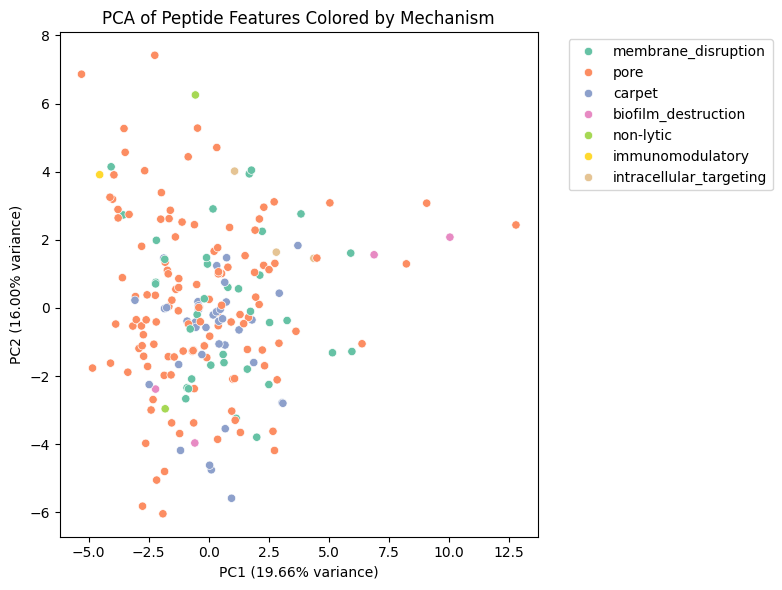

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="mechanism", palette="Set2")
plt.title("PCA of Peptide Features Colored by Mechanism")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=X.columns
).sort_values(by="PC1", key=abs, ascending=False)

print(loadings.head(10))  # Top features contributing to PC1
print(loadings)



                                     PC1       PC2
Boman Index (kcal/mol)          0.332359  0.129972
Hydrophobic Ratio              -0.320934 -0.110835
Percent R                       0.318169  0.066251
Charge Density (Charge/Dalton)  0.302181 -0.207182
Net Charge                      0.286733 -0.137620
Charge                          0.285998 -0.139190
Instability Index               0.275766  0.122036
Isoelectric Point (pH)          0.247508 -0.202256
Aliphatic Index                -0.224483 -0.214011
Flexibility Index               0.209679  0.216568
                                     PC1       PC2
Boman Index (kcal/mol)          0.332359  0.129972
Hydrophobic Ratio              -0.320934 -0.110835
Percent R                       0.318169  0.066251
Charge Density (Charge/Dalton)  0.302181 -0.207182
Net Charge                      0.286733 -0.137620
Charge                          0.285998 -0.139190
Instability Index               0.275766  0.122036
Isoelectric Point (pH)         

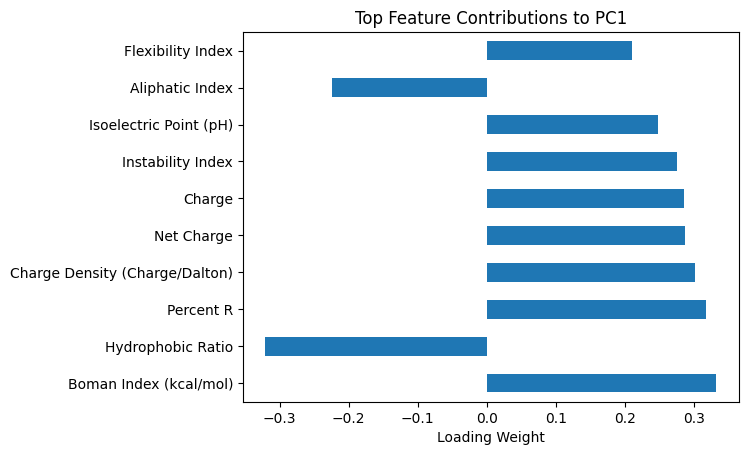

In [ ]:
loadings["abs_PC1"] = loadings["PC1"].abs()
loadings.sort_values("abs_PC1", ascending=False).head(10)["PC1"].plot(kind='barh')
plt.title("Top Feature Contributions to PC1")
plt.xlabel("Loading Weight")
plt.show()

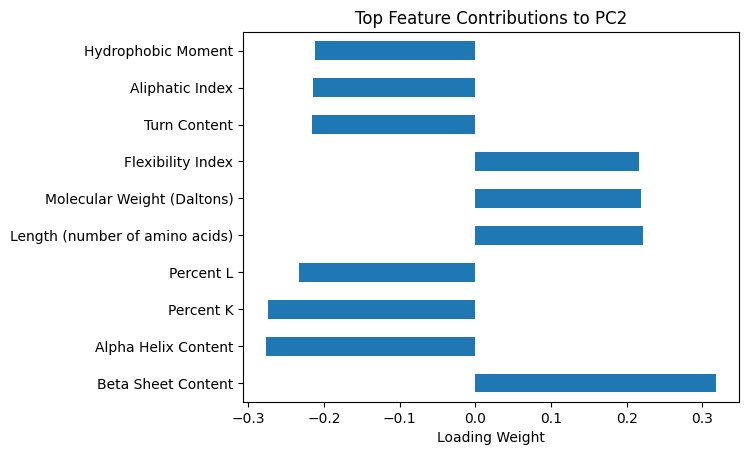

In [ ]:
loadings["abs_PC2"] = loadings["PC2"].abs()
loadings.sort_values("abs_PC2", ascending=False).head(10)["PC2"].plot(kind='barh')
plt.title("Top Feature Contributions to PC2")
plt.xlabel("Loading Weight")
plt.show()

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


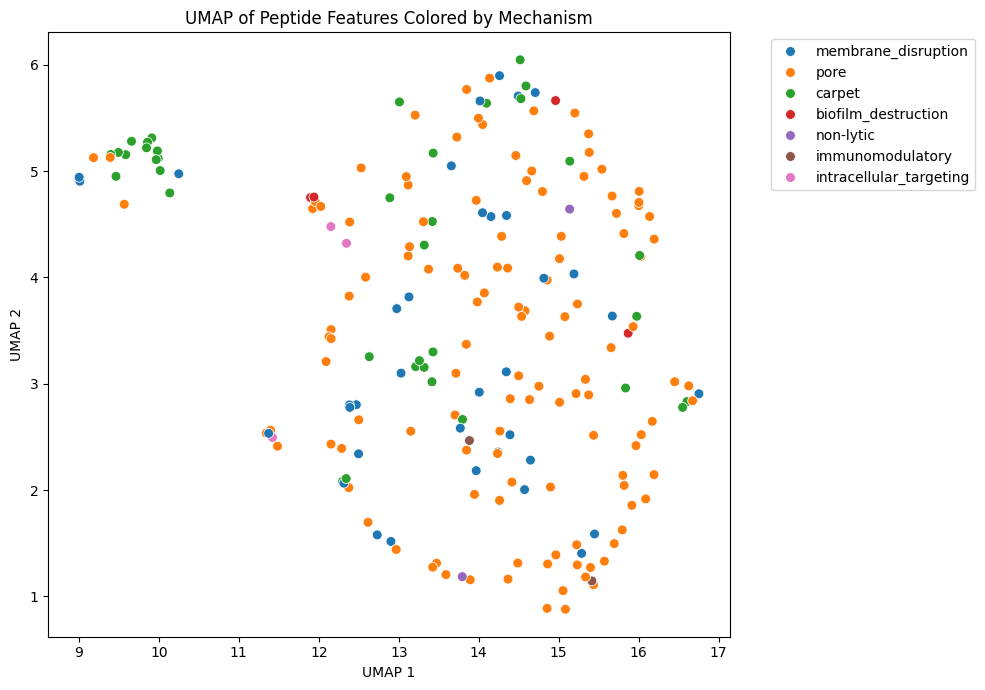

In [ ]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import umap.umap_ as umap  # pip install umap-learn

# === Step 1: Clean the data ===
clean_df = full_df[full_df["mechanism"].notnull() & (full_df["mechanism"] != "")]

# Store mechanism labels
mechanisms = clean_df["mechanism"].values

# Get numeric features only
X = clean_df.drop(columns=["id", "sequence", "subtype", "mechanism"])
X_scaled = StandardScaler().fit_transform(X)

# === Step 2: Run UMAP ===
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

# === Step 3: Plot UMAP colored by mechanism ===
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=mechanisms, palette="tab10", s=50)
plt.title("UMAP of Peptide Features Colored by Mechanism")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
umap_df = pd.DataFrame(X_umap, columns=["UMAP1", "UMAP2"])
feature_corrs = {
    feature: (
        umap_df["UMAP1"].corr(clean_df[feature]),
        umap_df["UMAP2"].corr(clean_df[feature])
    )
    for feature in X.columns
}
# Sort by strongest correlation to either axis
sorted_corrs = sorted(feature_corrs.items(), key=lambda x: max(abs(x[1][0]), abs(x[1][1])), reverse=True)
for feature, (c1, c2) in sorted_corrs[:10]:
    print(f"{feature}: UMAP1 corr = {c1:.2f}, UMAP2 corr = {c2:.2f}")


Aliphatic Index: UMAP1 corr = 0.71, UMAP2 corr = 0.09
Hydrophobic Ratio: UMAP1 corr = 0.65, UMAP2 corr = -0.18
Charge Density (Charge/Dalton): UMAP1 corr = -0.31, UMAP2 corr = 0.61
Beta Sheet Content: UMAP1 corr = -0.02, UMAP2 corr = -0.60
Percent W: UMAP1 corr = -0.59, UMAP2 corr = 0.36
Isoelectric Point (pH): UMAP1 corr = -0.37, UMAP2 corr = 0.58
Length (number of amino acids): UMAP1 corr = 0.16, UMAP2 corr = -0.58
Aromaticity: UMAP1 corr = -0.54, UMAP2 corr = 0.37
Molecular Weight (Daltons): UMAP1 corr = 0.06, UMAP2 corr = -0.52
Percent K: UMAP1 corr = 0.11, UMAP2 corr = 0.51


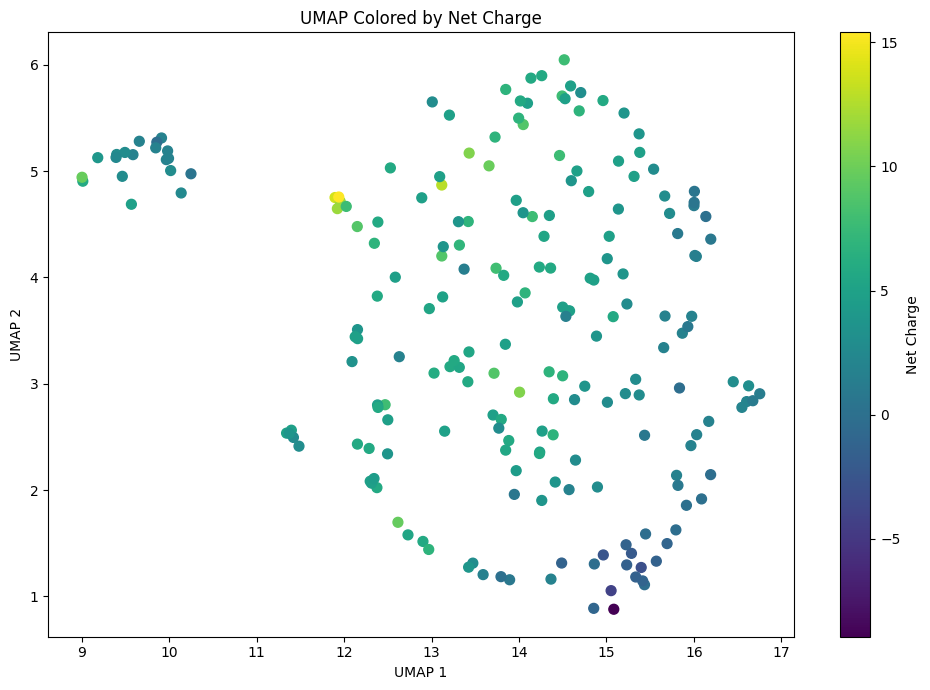

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the feature to color by (e.g., Net Charge)
color_feature = "Net Charge"

# Use the unscaled dataframe for getting the feature values
feature_values = X[color_feature]  # X is the original DataFrame, not the scaled array

# Create the UMAP plot colored by that feature
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=feature_values, cmap='viridis', s=50)
plt.colorbar(scatter, label=color_feature)
plt.title(f"UMAP Colored by {color_feature}")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

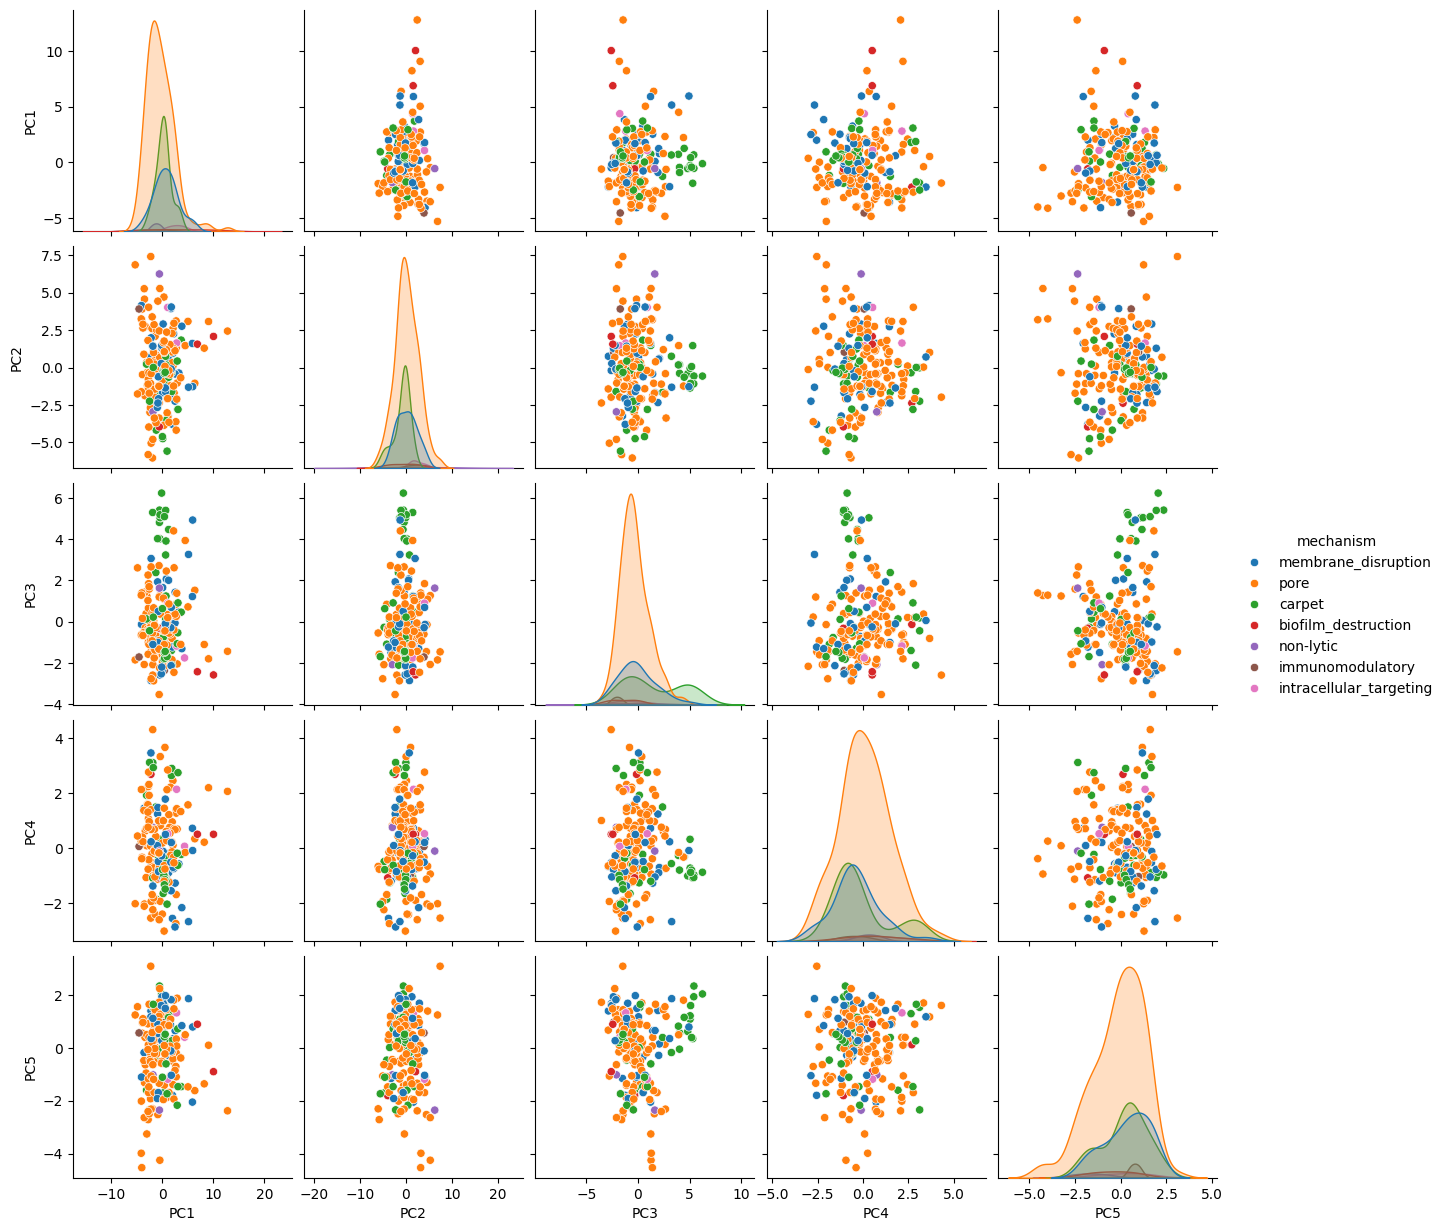

In [ ]:
import seaborn as sns
import pandas as pd

from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # You can go higher for explained variance analysis
X_pca = pca.fit_transform(X_scaled)

# Re-run PCA with more components
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# Now build the DataFrame
pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(5)])
pca_df['mechanism'] = mechanisms

# Generate the pairplot
pairplot = sns.pairplot(pca_df, hue='mechanism', diag_kind='kde')

# Save it to your Google Drive (make sure Google Drive is mounted)
pairplot.savefig("/content/drive/My Drive/Chen Lab/Antimicrobial Peptide Project/PCA_analysis.png", dpi=300)



/tmp/ipython-input-4242259139.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(unique_mechanisms))


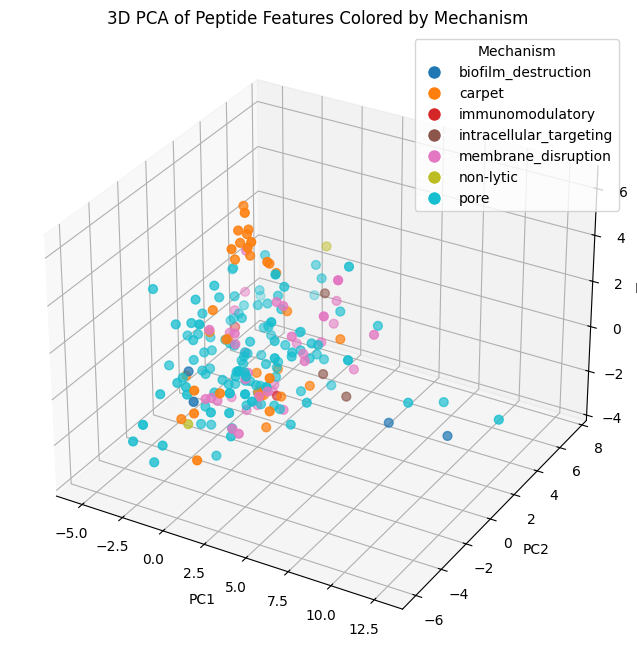

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
import pandas as pd

# Assume mechanisms is a pandas Series
unique_mechanisms = np.unique(mechanisms)
mechanism_to_int = {mech: idx for idx, mech in enumerate(unique_mechanisms)}
colors = cm.get_cmap('tab10', len(unique_mechanisms))

# Assign a color code for each point based on its mechanism
color_values = [mechanism_to_int[m] for m in mechanisms]

# Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=color_values, cmap='tab10', s=40
)

# Axis labels
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3D PCA of Peptide Features Colored by Mechanism")

# Manual legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=mech,
           markerfacecolor=colors(i), markersize=10)
    for i, mech in enumerate(unique_mechanisms)
]
ax.legend(handles=legend_elements, title="Mechanism", loc='upper right')

plt.show()


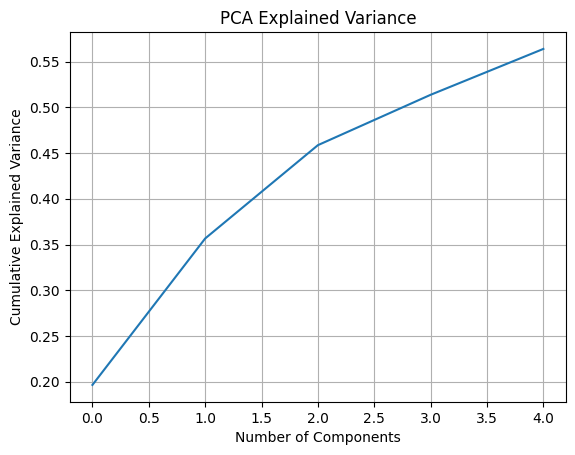

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()
